# Metadata Archivist

**Author:** Jose Villamar

The Metadata Archivist is a lightweight file processing framework designed to parse an arbitrary number of files with heterogenous formats and transform the results into a unified output.

This tutorial is designed to guide users through the first steps needed to:
1. Implement basic parsing functions by extending the abstract parsing class of the framework.
2. Structure the output of the parsers by providing a schema template
3. Instantiate and configure the Archivist controller to coordinate input files, parsers, and resulting output

**Note:** Installation instructions can be found in our [README](../../README.md).

## Example use case:

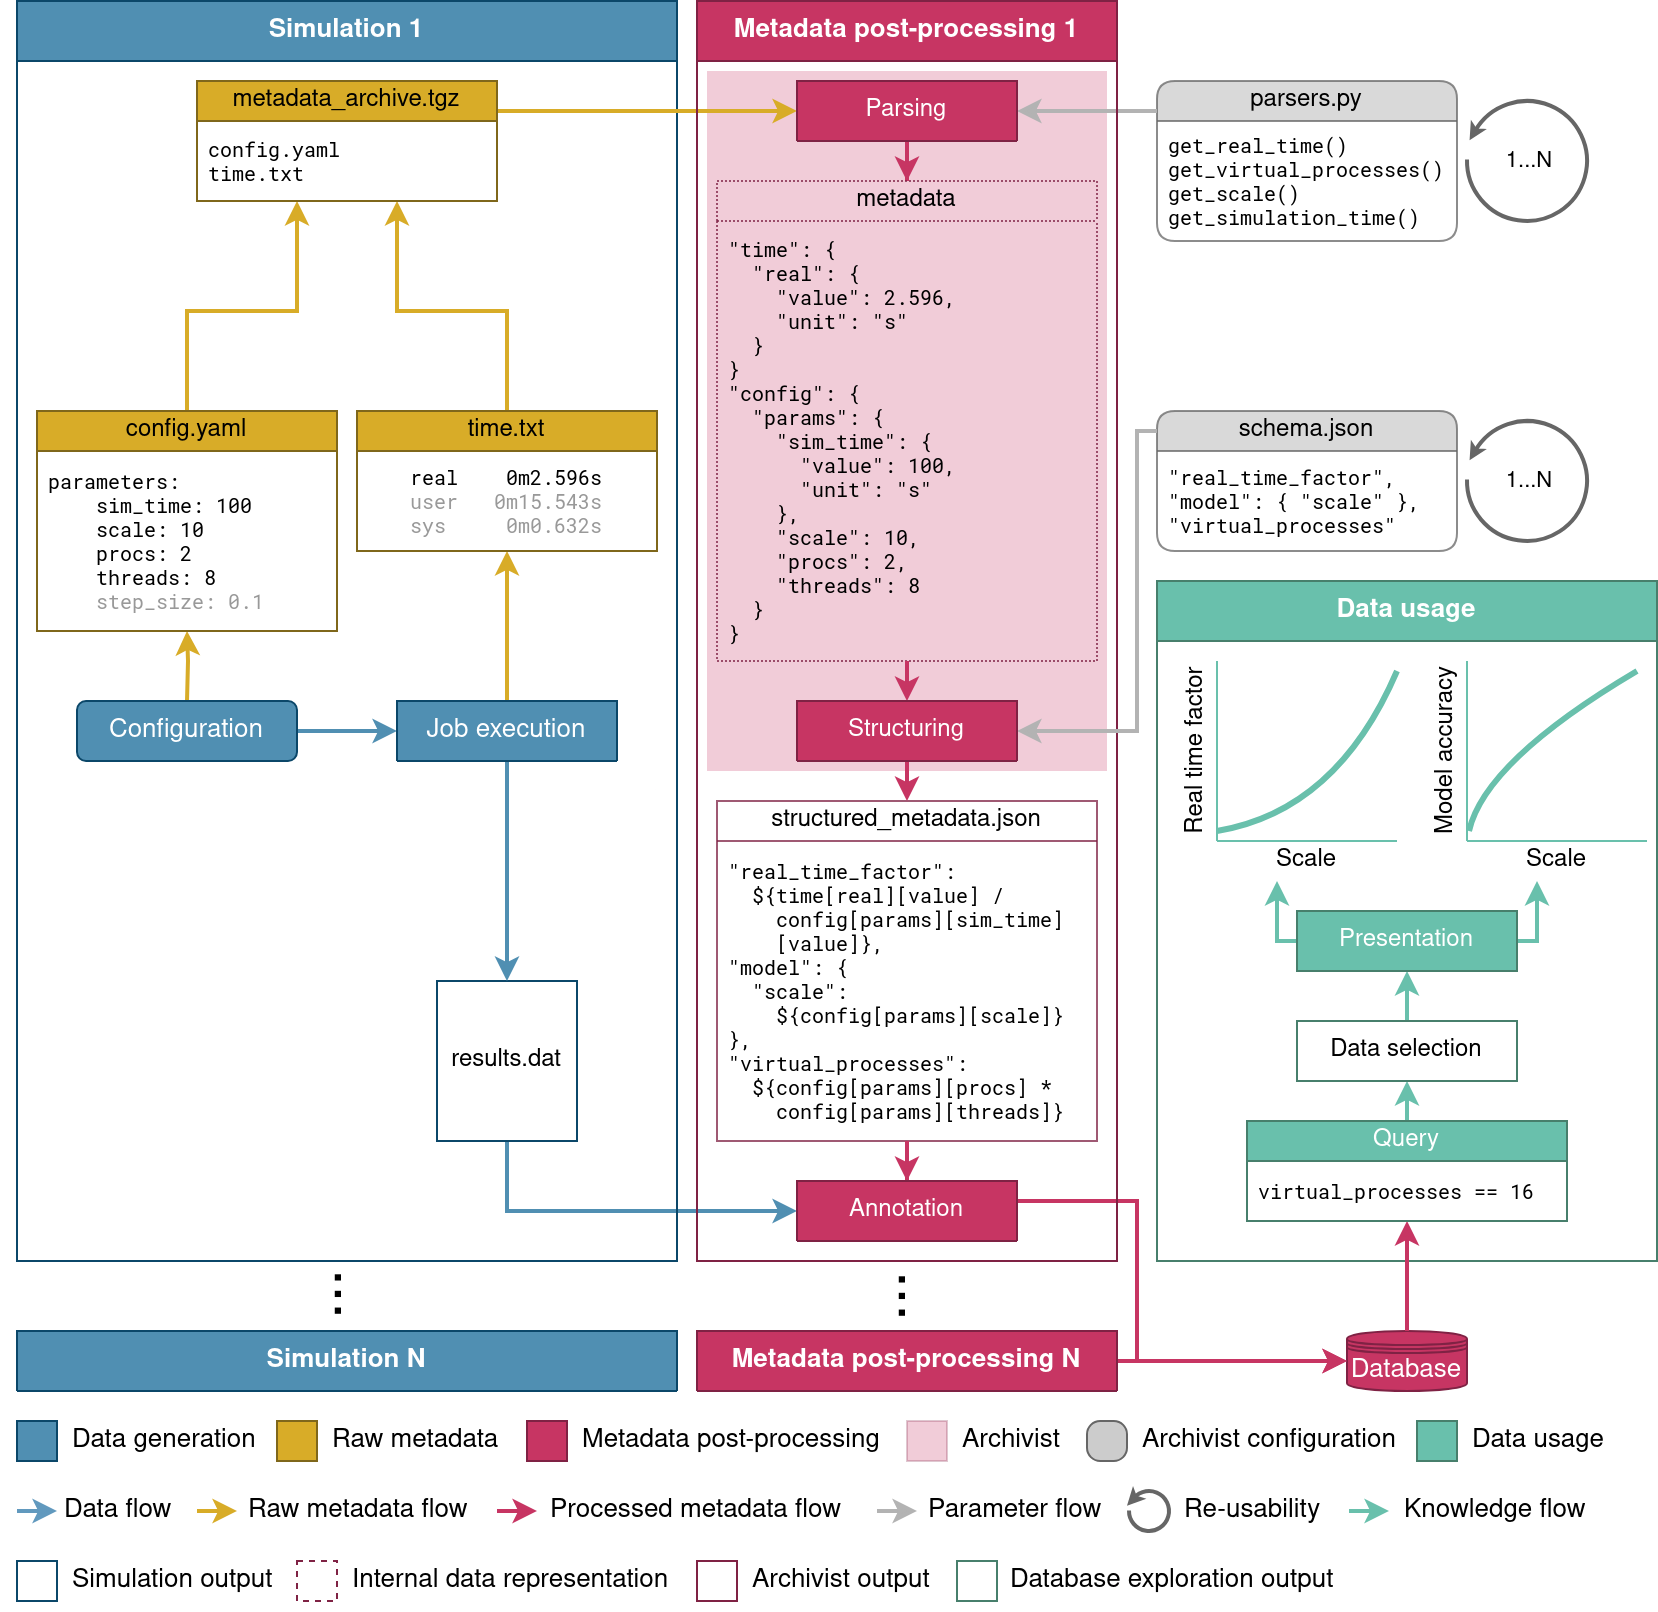

In [3]:
from IPython import display
png = display.Image(filename="../../docs/Minimal_Example_Workflow_Schema.png")
display.display_png(png)

In a parameter scanning experiment, several instances of a model with different configurations (parameters) are simulated (```Simulation 1 . . . Simulation N```; blue boxes on the left).
During each simulation, configuration and performance information are recorded and stored in a (raw) metadata archive (yellow).
After each simulation, the stored metadata is postprocessed (```Metadata post-processing 1 . . . Metadata post-processing N```; red):
first, the relevant information is extracted by calling a predefined parsing script (gray box ```parsers.py```).
Non-relevant information is discarded (see light gray text in the  raw metadata files).
The extracted metadata are then structured according to a provided schema (gray box ```schema.json```).
Finally, the simulation results are annotated with the structured metadata and stored in a database (red cylinder).
After all simulations and the metadata post-processing are finished and their results stored in the database, the annotated data can be queried and presented (green).

Excerpt from [DOI]()

## Now we will implement the metadata post-processing pipeline step by step:

### Necessary packages

In [1]:
# Import the archivist framework.
import metadata_archivist

# Additional packages used in this tutorial.
from json import dumps
from pathlib import Path
from yaml import safe_load

### Input files

As part of the tutorial an example collection of input files is provided in the ```raw_metadata``` directory.

#### config.yml
Generic configuration file containing several parameters:

In [2]:
print(Path("raw_metadata/config.yml").read_text())

parameters:
  sim_time: 100
  scale: 10
  num_procs: 2
  threads_per_proc: 8
  step_size: 0.1



#### time.txt
Output of unix time wrapper command:

In [3]:
print(Path("raw_metadata/time.txt").read_text())


real	0m2.596s
user	0m15.543s
sys	0m0.632s



### File parsers

To be able to handle the input files parsers need to be defined, here we opt for one for each file.
In principle, a parser could be implemented to process both files, however for simplicity and clarity we will proceed with two.

**Note**: Although parsers need to be implemented to be able to interact with the framework, there may already exist processing frameworks for certain file types, in this case the parser implementation becomes a wrapper around these processing framework. In this example we will use [PyYAML](https://pypi.org/project/PyYAML/) to load the contents of ```config.yml```.

In [4]:
# We first extend the abstract parser class from the metadata_archivist framework.
class yml_parser(metadata_archivist.AParser):
    # To instantiate the class a unique name is needed and the pattern of the file types that the parser can handle is needed.
    # This pattern is defined as a regular expression pointing to the file name.
    def __init__(self) -> None:
        super().__init__(
            name="yml_parser",
            # Note that this parser will process any .yml file.
            input_file_pattern=".*\.yml",
            # The output of the parser is described in the [JSON Schema](https://json-schema.org/overview/what-is-jsonschema) format.
            schema={
                "type": "object",
                "properties": {
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "sim_time": {
                                "type": "number",
                                "description": "total time to simulate in seconds",
                            },
                            "scale": {"type": "number", "description": "model scale"},
                            "num_procs": {
                                "type": "number",
                                "description": "number of MPI processes",
                            },
                            "threads_per_proc": {
                                "type": "number",
                                "description": "number of threads used per MPI process",
                            },
                            "step_size": {
                                "type": "number",
                                "description": "step size for advancing simulation",
                            },
                        },
                    }
                },
            },
        )

    # Then the virtual parse method needs to be defined, here we use the yaml package to load the contents of the file.
    def parse(self, file_path):
        out = None
        with file_path.open() as fp:
            out = safe_load(fp)
        return out


# To help processing the time.txt file we create two functions:
def time_parser_sec(string: str) -> float:
    """ "
    This functions reads a string containing time duration information in ASCII format (output from the time command) and returns its value in seconds.

    Arguments:
        string: time duration information in ASCII format (output from the time command)

    Returns:
        float value of the duration in seconds
    """
    minute_split = string.split("m")
    minutes = int(minute_split[0]) * 60 * 1000
    second_split = minute_split[1].split(".")
    seconds = int(second_split[0]) * 1000
    milis = int(second_split[1][:-1])
    return (minutes + seconds + milis) / 1000


def key_val_split(string: str, split_char: str, functor=None):
    """
    Basic ASCII text processing function.
    Assumes input string contains a key value pair type of information, using a marker character splits the string and returns the key value pair as object.
    Optionally values can be transformed using a provided function.

    Arguments:
        string: ASCII string containing key value pair information
        split_char: ASCII character used as marker between key and value
        functor: Optional. Callable used to transform value information

    Returns:
        object containing key value pair
    """
    if functor is None:
        functor = lambda x: x
    string = string.strip()
    out = string.split(split_char)
    return {out[0].strip(): functor(out[1].strip())}


# Now our second parser.
class time_parser(metadata_archivist.AParser):

    def __init__(self) -> None:
        super().__init__(
            name="time_parser",
            # Note that this parser will only process files named time.txt.
            input_file_pattern="time\.txt",
            # The output of the parser is described in the [JSON Schema](https://json-schema.org/overview/what-is-jsonschema) format.
            schema={
                "type": "object",
                "properties": {
                    "real": {
                        "type": "number",
                        "description": "the time from start to finish of the call in seconds",
                    },
                    "user": {
                        "type": "number",
                        "description": "amount of CPU time spent in user mode in seconds",
                    },
                    "sys": {
                        "type": "number",
                        "description": "amount of CPU time spent in kernel mode in seconds",
                    },
                    "system": {"$ref": "#/properties/sys"},
                },
            },
        )

    def parse(self, file_path) -> dict:
        out = {}
        with file_path.open("r") as fp:
            for line in fp:
                if line != "\n":
                    out.update(key_val_split(line, "\t", time_parser_sec))
        return out

### Structuring with a schema

To be able to structure the output of parsers a schema template describing the combined output needs to be provided.
This schema description is based on the [JSON Schema language](https://json-schema.org/learn/glossary) with additional clauses to describe structuring operations.
JSON Schema is a declarative language used to define the structure and constraints of JSON data, enabling validation and ensuring data quality. It utilizes a set of keywords to specify the properties and rules for JSON documents, allowing developers to enforce consistency and interoperability across systems.


Here we use:
* ```!parsing``` directive which introduces the usage of parsing results of a single parser.
* ```!calculate``` directive which combines through simple arithmetic the parsing results of two or more parsers.

In [5]:
# The schema template is defined as a dictionary object, naturally, it can also be stored as a JSON file.
my_schema = {
    # Dialect of JSONSchema known by the framework.
    "$schema": "https://json-schema.org/draft/2020-12/schema",
    # As the template is based on the JSON Schema language, we use the standard headers for our schema files.
    "description": "my example schema",
    "type": "object",
    "properties": {
        # Here property name refers to the actual keys in the output data.
        "real_time_factor": {
            "type": "number",
            "description": "ratio of wall clock time to simulation time",
            # Calculate directive used to compute arithmetic expressions using parsing results of two or more parsers.
            "!calculate": {
                # The expression is defined as a string, variables can be defined inside of curly brackets.
                "expression": "{val1} / {val2}",
                # For each variable, its corresponding value from a parsing results needs to be defined.
                "variables": {
                    "val1": {
                        # The parsing directive replaces the contents of the object with the parsing results of the referenced parser.
                        "!parsing": {
                            # Here we select a subset of the available results filtered using a specific key (or set of keys).
                            "keys": ["real"],
                            # The selection result is returned as a key value pair. If only the value is needed, it can be "un-packed".
                            # Here we only need to unpack a single structure.
                            "unpack": 1,
                        },
                        # Reference to the parser definition, in this framework parsers are automatically added to the definition sections of the schema.
                        # These can be referenced through the unique name provided during class instantiation.
                        "$ref": "#/$defs/time_parser",
                    },
                    "val2": {
                        "!parsing": {
                            # If the desired information is found inside a nested structure,
                            # this nesting can be indicated as a path inside the structure where each key is separated by '/' .
                            # Here subsequent keys means a deeper location inside the structure.
                            "keys": ["parameters/sim_time"],
                            # As we obtain a 2 level nested structure, the unpacking level also needs to be raised.
                            "unpack": 2,
                        },
                        "$ref": "#/$defs/yml_parser",
                    },
                },
            },
        },
        "model": {
            "!parsing": {
                "keys": ["parameters/scale"],
                # Although a nested structure is selected here by parameters/scale (equivalent to parsing_results["parameters"]["scale"]).
                # We actually desire to have a scale: value key pair, hence we only use a single unpacking level.
                "unpack": 1,
            },
            "$ref": "#/$defs/yml_parser",
        },
        "virtual_processes": {
            "type": "number",
            "description": "total number of digital processing units, number of processes multiplied by number of computing threads per process",
            "!calculate": {
                "expression": "{val1} * {val2}",
                "variables": {
                    "val1": {
                        "!parsing": {
                            "keys": ["parameters/num_procs"],
                            # In case we ultimately only desire terminal values from the selected structures,
                            # unpack can be set to true and the selection result will be unpacked to the highest level possible.
                            "unpack": True,
                        },
                        "$ref": "#/$defs/yml_parser",
                    },
                    "val2": {
                        "!parsing": {
                            "keys": ["parameters/threads_per_proc"],
                            "unpack": True,
                        },
                        "$ref": "#/$defs/yml_parser",
                    },
                },
            },
        },
    },
}

### Getting all together

To be able to handle an arbitrary number of parsers and interpret the schema, the Metadata Archivist framework employs a ```Formatter``` class which handles parsing execution and structuring of its output.
Together with the ```Archivist``` class which handles directory or archive exploration and exporting the structured output, the framework is capable of handling an arbitrary number of files and formats resulting in an unified structured output.

In [8]:
# To instantiate the Archivist class:
# a path to the desired exploration directory or archive,
# a list of parsers to use,
# and optionally a schema must be provided.
arch = metadata_archivist.Archivist(
    path="raw_metadata",
    parsers=[time_parser(), yml_parser()],
    schema=my_schema,
    add_description=True,
    add_type=True,
    verbosity="warning",
)

arch.parse()

print("Resulting schema:")
print(dumps(arch.get_formatted_schema(), indent=4))

print("\nResulting metadata:")
print(dumps(arch.get_metadata(), indent=4))

Resulting schema:
{
    "$schema": "https://json-schema.org/draft/2020-12/schema",
    "description": "my example schema",
    "type": "object",
    "properties": {
        "real_time_factor": {
            "type": "number",
            "description": "ratio of wall clock time to simulation time"
        },
        "model": {
            "$ref": "#/$defs/yml_parser"
        },
        "virtual_processes": {
            "type": "number",
            "description": "total number of digital processing units, number of processes multiplied by number of computing threads per process"
        }
    },
    "$defs": {
        "node": {
            "properties": {
                "anyOf": [
                    {
                        "$ref": "#/$defs/time_parser"
                    },
                    {
                        "$ref": "#/$defs/yml_parser"
                    },
                    {
                        "$ref": "#/$defs/time_parser"
                    },
             

## Moving forward

The newly structured metadata gives a quick description of the experiment configuration and results at hand and can be used to enrich the experiment data for further uses.

As illustrated in the example use case shown at the beginning of this tutorial, the structured metadata can be fed to a database, then after several trials of simulation and reusing the post-processing pipeline, the database can be queried to extract broader observations on the simulation technology or model implementation.

## Other examples

This example builds upon all current features present in the framework, however a sequence examples showcasing each feature of the framework is available in the [examples directory](../../examples/).